# Setup

In [1]:
import json
import os
import sys
import pickle
import warnings

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from flaml import AutoML

from sklearn.metrics import balanced_accuracy_score, median_absolute_error

from utils import read_csv_non_utf, preprocess_data, ratios_to_DI_cats, get_train_test_split, \
                  get_zero_nonzero_datasets, test_thresholds, direct_train_test
from model_utils import HurdleModelEstimator
from custom_metrics import balanced_accuracy_FLAML
from performance_reports import get_regression_report, get_classification_report

## Loading the data

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']
ferreiro_arias2024 = config['indiv_data_paths']['ferreiro_arias2024']

ben_lop_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)
fer_ari_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, ferreiro_arias2024)

In [3]:
# Choosing the dataset - "mammals" or "birds"
dataset = 'birds'

# Reading in the dataset
if dataset == 'birds':
    data = pd.read_csv(fer_ari_path)
elif dataset == 'mammals':
    data = read_csv_non_utf(ben_lop_path)

data.head()

,Study,Dataset,Reviewer,Order,Family,Species,BirdLife_Species,BirdTree_Species,IUCN_Species,Hunting,...,TravDist,PopDens,Stunting,FoodBiomass,Reserve,Forest_cover,NPP,CountryNum,Food,Hunted
0,442,9,AB,Galliformes,Cracidae,Mitu tuberosum,Mitu tuberosum,Mitu tuberosum,Mitu tuberosum,S,...,2389.0,0.0,14.7,17.695656,1,100.0,207.0,76,Yes,Yes
1,442,9,AB,Galliformes,Cracidae,Mitu tuberosum,Mitu tuberosum,Mitu tuberosum,Mitu tuberosum,S,...,2389.0,0.0,14.7,17.695656,1,100.0,207.0,76,Yes,Yes
2,442,9,AB,Galliformes,Cracidae,Mitu tuberosum,Mitu tuberosum,Mitu tuberosum,Mitu tuberosum,S,...,2389.0,0.0,14.7,17.695656,1,100.0,207.0,76,Yes,Yes
3,442,9,AB,Galliformes,Cracidae,Mitu tuberosum,Mitu tuberosum,Mitu tuberosum,Mitu tuberosum,S,...,2389.0,0.0,14.7,17.695656,1,100.0,207.0,76,Yes,Yes
4,442,9,AB,Galliformes,Cracidae,Mitu tuberosum,Mitu tuberosum,Mitu tuberosum,Mitu tuberosum,S,...,2389.0,0.0,14.7,17.695656,1,100.0,207.0,76,Yes,Yes


# Direct regression and classificaiton

I am using Microsoft's [`flaml`](https://github.com/microsoft/FLAML) for AutoML, which supports a range of models: 
- [Light Gradient Boosting Machine (LGBM)](https://github.com/microsoft/LightGBM),
- [Extreme Gradient Boosting (XGBoost)](https://github.com/dmlc/xgboost),
- [Random Forest (RF)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor),
- [Extra Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html),
- [Histogram Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor),
- [Categorical Boosting (CatBoost)](https://github.com/catboost/catboost),
- [$k$-Nearest Neighbors ($k$-NN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html).

Noticeably, linear models and neural networks are missing from the mix, but we may be able to use `flaml` to perform [efficient hyperparameter tuning](https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#guidelines-on-tuning-a-custom-estimator) on these using `sklearn` or `PyTorch` implementations.

In [17]:
# Getting train/test data
task = 'regression'
X_train, y_train, X_test, y_test = direct_train_test(data, train_size = 0.7, task = task, dataset = dataset)

print(f'{task.upper()} TARGET')
print(f'Train shape: X{X_train.shape}, y{y_train.shape}')
print(f'Test shape: X{X_test.shape}, y{y_test.shape}')

REGRESSION TARGET
Train shape: X(1038, 9), y(1038,)
Test shape: X(446, 9), y(446,)


In [18]:
# Initialize the auto ML instance
automl = AutoML()
time_budget_mins = 2

# Specify paramaters
base_path = os.path.join('..', 'model_saves', f'direct_{task}')
automl_settings = {
    'time_budget' : time_budget_mins * 60,  # in seconds
    'metric' : 'mae' if task == 'regression' else balanced_accuracy_FLAML,
    'task' : task,
    'log_file_name' : os.path.join(base_path, f'{dataset}_direct_{task}.log'),
    'seed' : 1693,
    'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
    'early_stop' : True,
    'verbose' : 3
}

# Train with labeled input data
automl.fit(X_train = X_train, y_train = y_train, **automl_settings)

[flaml.automl.logger: 06-12 16:22:07] {1680} INFO - task = regression
[flaml.automl.logger: 06-12 16:22:07] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 06-12 16:22:07] {1789} INFO - Minimizing error metric: mae
[flaml.automl.logger: 06-12 16:22:07] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor']
[flaml.automl.logger: 06-12 16:22:07] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-12 16:22:07] {2345} INFO - Estimated sufficient time budget=2240s. Estimated necessary time budget=23s.
[flaml.automl.logger: 06-12 16:22:07] {2392} INFO -  at 0.3s,	estimator lgbm's best error=0.9617,	best estimator lgbm's best error=0.9617
[flaml.automl.logger: 06-12 16:22:07] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-12 16:22:07] {2392} INFO -  at 0.5s,	estimator lgbm's best error=0.9617,	best estimator lgbm's best error=0.9617
[flaml.automl.logger: 06-12 16:22:07] {2

CLASSIFICATION PERFORMANCE
--------------------------
              precision    recall  f1-score   support

         low       0.52      0.71      0.60       184
      medium       0.34      0.44      0.39       150
        high       0.50      0.01      0.02       112

    accuracy                           0.44       446
   macro avg       0.45      0.39      0.33       446
weighted avg       0.46      0.44      0.38       446

Balanced accuracy: 38.7%


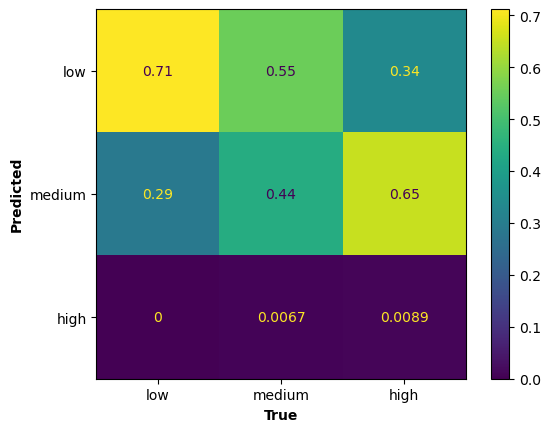


REGRESSION PERFORMANCE
----------------------
Mean absolute error: 0.858
Median absolute error: 0.58
Root mean squared error: 1.547
Root median squared error: 0.58


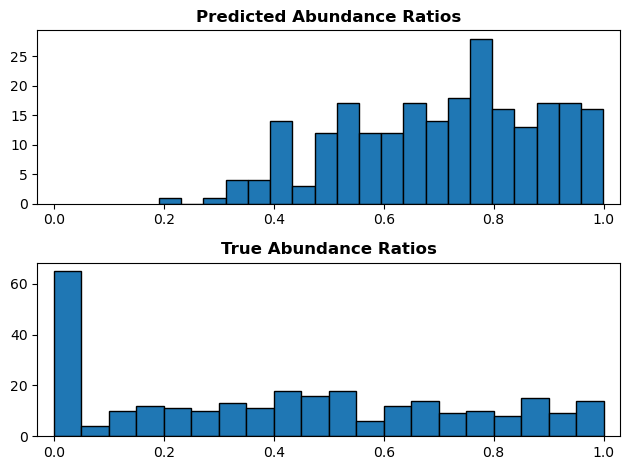

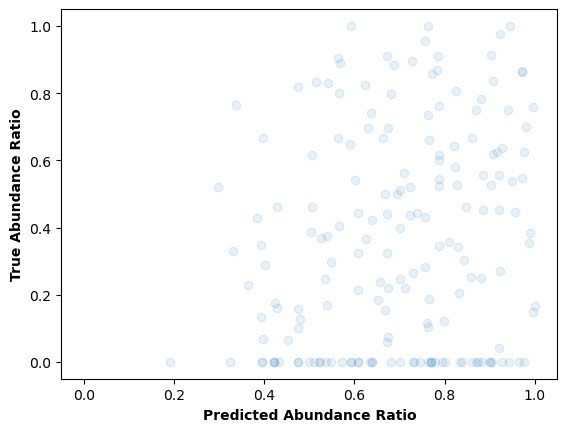

In [19]:
# Getting regression and classification true vs. predicted
if task == 'regression':
    pred_ratios = automl.predict(X_test)
    test_ratios = y_test

    pred_DI_cats = ratios_to_DI_cats(pred_ratios)
    true_DI_cats = ratios_to_DI_cats(test_ratios)
elif task == 'classification':
    pred_DI_cats = automl.predict(X_test)
    true_DI_cats = y_test

print('CLASSIFICATION PERFORMANCE')
print('--------------------------')
get_classification_report(true_DI_cats, pred_DI_cats, printout = True)

if task == 'regression':
    print()
    print('REGRESSION PERFORMANCE')
    print('----------------------')
    get_regression_report(test_ratios, pred_ratios, printout = True)

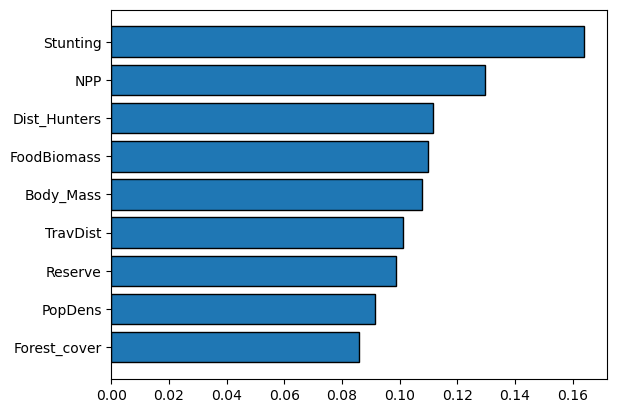

In [20]:
# Taking a look at feature importance
features = np.array(automl.model.feature_names_in_)
importances = np.array(automl.model.feature_importances_)
sort_order = np.argsort(importances)

plt.barh(features[sort_order], importances[sort_order], edgecolor = 'black');
# plt.xlabel(f'Importance type: {automl.model.estimator.importance_type}', weight = 'bold');

# Non-linear hurdle model via AutoML

What if we use AutoML to find the best regression and classification models for a two-stage hurdle model?

In [21]:
# Preparing the data for the zero and nonzero models
idxs = get_train_test_split(len(data), train_size = 0.7)

embeddings_to_use = None
embeddings_args = {'pca' : False,
                   'var_cutoff' : 0.9}
pp_data = preprocess_data(data, include_indicators = False, standardize = True, log_trans_cont = False,
                          polynomial_features = 0, train_test_idxs = idxs, embeddings_to_use = embeddings_to_use,
                          embeddings_args = embeddings_args, dataset = dataset)

train_data, test_data = pp_data.iloc[idxs['train']], pp_data.iloc[idxs['test']]

In [25]:
# General parameters
time_budget_mins = 2
base_path = os.path.join('..', 'model_saves')
verbose = 3

if dataset == 'mammals':
    zero_columns = ['BM', 'DistKm', 'PopDens', 'Stunting', 'TravTime', 'LivestockBio', 'Literacy', 'Reserve']
elif dataset == 'birds':
    zero_columns = ['Dist_Hunters', 'TravDist', 'PopDens', 'Stunting', 'FoodBiomass', 'Forest_cover', 'NPP', 'Body_Mass']
nonzero_columns = zero_columns
indicator_columns = []

zero_metric = balanced_accuracy_FLAML
nonzero_metric = 'mse'

# Setting up the zero and nonzero models
zero_model = AutoML()
nonzero_model = AutoML()

#  specify fitting paramaters
zero_settings = {
    'time_budget' : time_budget_mins * 60,  # in seconds
    'metric' : zero_metric,
    'task' : 'classification',
    'log_file_name' : os.path.join(base_path, f'nonlinear_hurdle_ZERO.log'),
    'seed' : 1693,
    'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 
                        'extra_tree', 'kneighbor', 'lrl1', 'lrl2'],
    'early_stop' : True,
    'verbose' : verbose,
    'keep_search_state' : True,
    'eval_method' : 'cv'
}

nonzero_settings = {
    'time_budget' : time_budget_mins * 60,  # in seconds
    'metric' : nonzero_metric,
    'task' : 'regression',
    'log_file_name' : os.path.join(base_path, f'nonlinear_hurdle_NONZERO.log'),
    'seed' : 1693,
    'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
    'early_stop' : True,
    'verbose' : verbose,
    'keep_search_state' : True,
    'eval_method' : 'cv'
}

extirp_pos = False
settings = {'zero' : zero_settings, 'nonzero' : nonzero_settings}

#  dumping everything into the hurdle model wrapper
data_args = {'indicator_columns' : indicator_columns,
             'nonzero_columns' : nonzero_columns,
             'zero_columns' : zero_columns,
             'embeddings_to_use' : embeddings_to_use,
             'dataset' : dataset}
hurdle_model = HurdleModelEstimator(zero_model, nonzero_model, extirp_pos = extirp_pos, 
                                    data_args = data_args, verbose = True)

In [27]:
# Fitting the two constituent models
hurdle_model.fit(train_data, fit_args = settings)

Fitting the nonzero model...
[flaml.automl.logger: 06-12 16:32:01] {1680} INFO - task = regression
[flaml.automl.logger: 06-12 16:32:01] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 06-12 16:32:01] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 06-12 16:32:01] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor']
[flaml.automl.logger: 06-12 16:32:01] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-12 16:32:02] {2345} INFO - Estimated sufficient time budget=2096s. Estimated necessary time budget=21s.
[flaml.automl.logger: 06-12 16:32:02] {2392} INFO -  at 0.3s,	estimator lgbm's best error=0.8876,	best estimator lgbm's best error=0.8876
[flaml.automl.logger: 06-12 16:32:02] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-12 16:32:02] {2392} INFO -  at 0.4s,	estimator lgbm's best error=0.8726,	best estimator lgbm's best error=0.8726
[flaml.auto

In [28]:
# Checking which models were chosen
print('Nonzero model:', hurdle_model.nonzero_model.model.estimator_class)
print('Zero model:', hurdle_model.zero_model.model.estimator_class)

Nonzero model: <class 'lightgbm.sklearn.LGBMRegressor'>
Zero model: <class 'lightgbm.sklearn.LGBMClassifier'>


In [29]:
# Looking at the best hyperparameters
print(hurdle_model.nonzero_model.best_config)
print()
print(hurdle_model.zero_model.best_config)

{'n_estimators': 4, 'num_leaves': 9, 'min_child_samples': 30, 'learning_rate': 0.29689707000540855, 'log_max_bin': 6, 'colsample_bytree': 0.7642911568922484, 'reg_alpha': 0.004384307679744976, 'reg_lambda': 2.3803959528507472}

{'n_estimators': 50, 'num_leaves': 40, 'min_child_samples': 8, 'learning_rate': 0.7122290407873098, 'log_max_bin': 7, 'colsample_bytree': 0.7672383914807226, 'reg_alpha': 0.004908286654876255, 'reg_lambda': 0.12725546171078198}


In [30]:
# Tuning the threshold for the zero model
X_zero, y_zero, _, _ = get_zero_nonzero_datasets(train_data, extirp_pos = extirp_pos, pred = False, **data_args)
y_pred = hurdle_model.zero_model.predict_proba(X_zero)[ : , 1]

opt_thresh, metrics = test_thresholds(y_pred, y_zero)
hurdle_model.prob_thresh = round(opt_thresh, 3)
print(f'Best threshold was found to be {round(opt_thresh, 3)} with a TSS of {round(np.max(metrics["TSS"]), 3)}')

Best threshold was found to be 0.8 with a TSS of 0.974


In [32]:
# Predicting with the final hurdle model
resp_col = 'ratio' if dataset == 'mammals' else 'RR'
y_test = test_data[resp_col]
y_pred = hurdle_model.predict(test_data)
y_pred[y_pred != 0] = np.exp(y_pred[y_pred != 0])

pred_DI_cats = ratios_to_DI_cats(y_pred)
true_DI_cats = ratios_to_DI_cats(y_test)

CLASSIFICATION PERFORMANCE
--------------------------
              precision    recall  f1-score   support

         low       0.52      0.49      0.51       184
      medium       0.39      0.52      0.45       150
        high       0.59      0.38      0.46       112

    accuracy                           0.48       446
   macro avg       0.50      0.47      0.47       446
weighted avg       0.49      0.48      0.48       446

Balanced accuracy: 46.62%


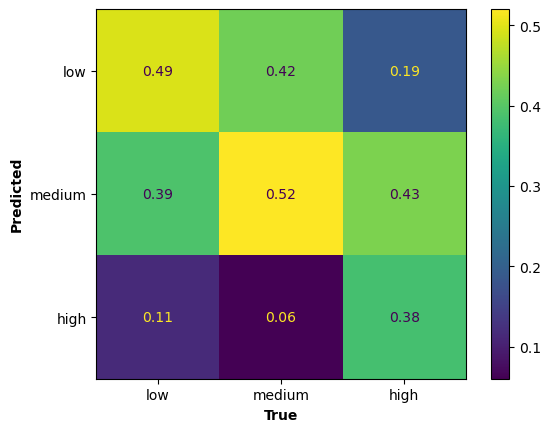


REGRESSION PERFORMANCE
----------------------
Mean absolute error: 0.781
Median absolute error: 0.447
Root mean squared error: 1.61
Root median squared error: 0.447


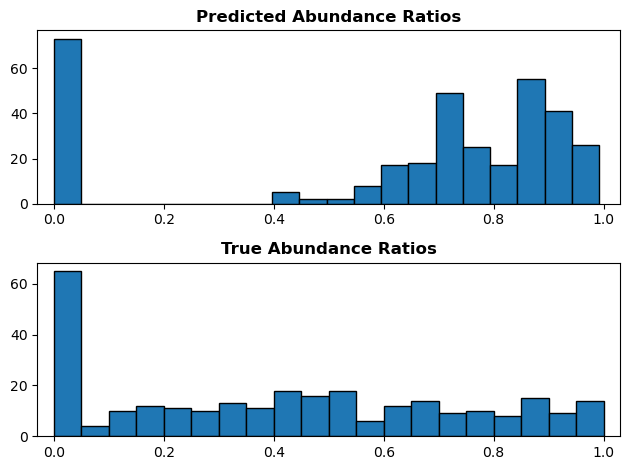

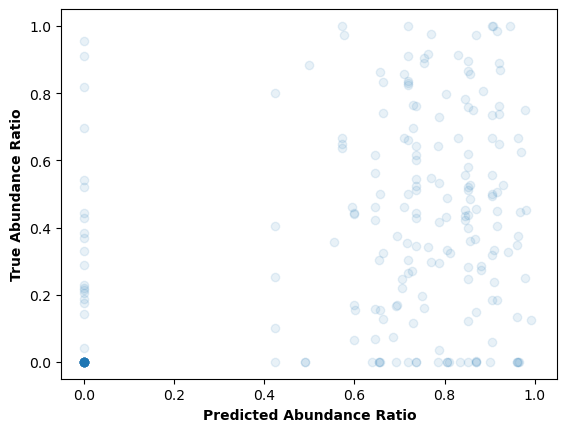

In [33]:
# Assessing classification and regression performance
upper_thresh = 1

print('CLASSIFICATION PERFORMANCE')
print('--------------------------')
get_classification_report(true_DI_cats, pred_DI_cats, printout = True)

print()

print('REGRESSION PERFORMANCE')
print('----------------------')
get_regression_report(y_test, y_pred, printout = True, upper_thresh = upper_thresh)

In [73]:
feats = []

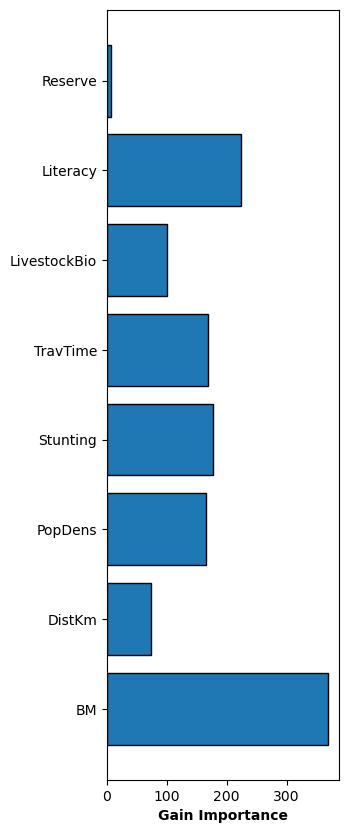

In [113]:
# Check feature importance
model = hurdle_model.zero_model
model.model.estimator.importance_type = 'gain'

imp = model.feature_importances_
feat = np.array(model.feature_names_in_)

# imp_mask = imp > np.percentile(imp, 95)
# imp_mask = imp != 0
# imp = imp[imp_mask]
# feat = feat[imp_mask]
feats.append(feat)

plt.figure(figsize = (3, 10))
plt.barh(feat, imp, edgecolor = 'black')
plt.xlabel('Gain Importance', weight = 'bold')

# plt.savefig('/Users/emiliolr/Desktop/feature_importances_nonzero.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [76]:
set(feats[0]).intersection(set(feats[1]))

{'satclip_10',
 'satclip_11',
 'satclip_12',
 'satclip_13',
 'satclip_18',
 'satclip_2',
 'satclip_3',
 'satclip_8'}

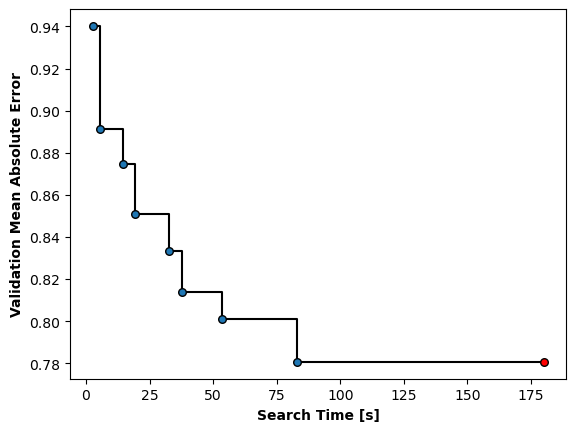

In [96]:
# An proof-of-concept for plotting the learning curve
from flaml.automl.data import get_output_from_log

model = 'nonzero'
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = get_output_from_log(filename = os.path.join(base_path, f'nonlinear_hurdle_{model.upper()}.log'), 
                                                                                                                time_budget = time_budget_mins * 60)
time_history.append(time_budget_mins * 60)
best_valid_loss_history.append(best_valid_loss_history[-1])

y_vals = 1 - np.array(best_valid_loss_history) if model == 'zero' else np.array(best_valid_loss_history)
plt.step(time_history, y_vals, where = 'post', color = 'black', zorder = 0)
plt.scatter(time_history[ : -1], y_vals[ : -1], s = 30, edgecolor = 'black', zorder = 100)
plt.scatter(time_history[-1], y_vals[-1], s = 30, edgecolor = 'black', color = 'red', zorder = 100)

y_label = 'Validation Balanced Accuracy' if model == 'zero' else 'Validation Mean Absolute Error'
plt.ylabel(y_label, weight = 'bold')
plt.xlabel('Search Time [s]', weight = 'bold')

# plt.savefig(f'/Users/emiliolr/Desktop/learning_curve_{model}.png', dpi = 300, bbox_inches = 'tight')
plt.show()